<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod3/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod3/rf.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

[Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) and [Random Forests](https://en.wikipedia.org/wiki/Random_forest)
---
_homl3 ch7_

In [51]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

# Wisdom of the crowd
- A group of predictors usually make better predictions than the best individual predictor
  - they are called an *ensemble*
  - this technique is called *ensemble learning*
  - an ensemble learning algorithm is called an *ensemble method*, such as
    - voting classifiers, 
    - bagging and pasting ensembles, 
    - random forests, 
    - boosting, and stacking ensembles
- Ensemble methods are versatile, powerful, and fairly simple to use
  - particularly good at heterogeneous tabular data
  - require very little preprocessing
  - great for quick ML prototyping
  - help push a ML system’s performance to its limits

# Voting Classifiers
- two types:  
  - hard voting classifier and soft voting classifier
- hard voting classifier
  - aggregates the predictions from a group of diverse classifiers
  - the class that gets the most votes is the ensemble’s prediction
- voting classifier often achieves a higher accuracy than the best classifier in the ensemble
  - even true for each classifier slightly better than random guessing
  - if the voting classifier has enough members 
    - and they are sufficiently diverse,
    - and they are sufficiently independent from each other
    - this is an ideal condition, in the real world,
      - these classifiers are trained on the same dataset
      - so they make similar errors and reduce the ensemble's accuracy
  - the principle behind this phenomenon is *the law of large numbers* 
  - it is implemented as the sklearn class VotingClassifier

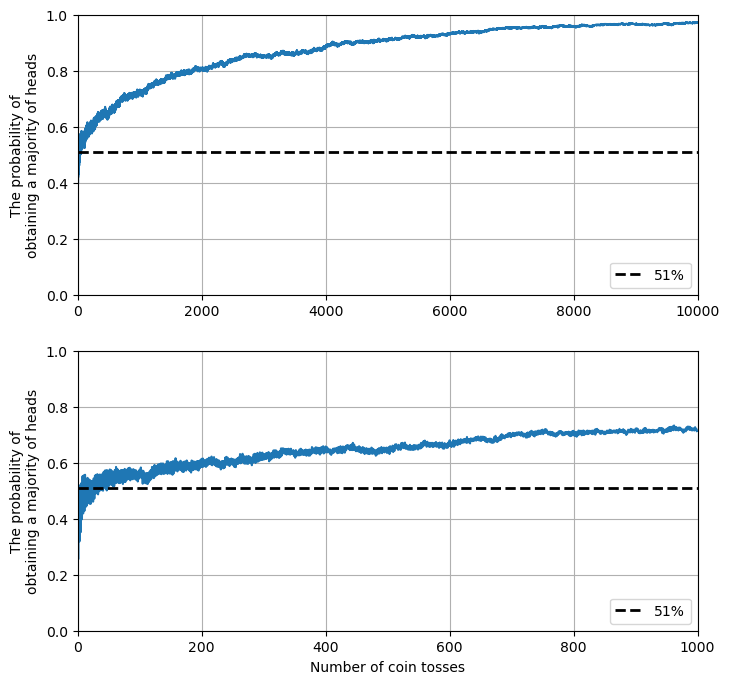

In [93]:
# An analog demonstrating the `Wisdom of the crowd`
# 1. toss a slightly biased coin that has a 51% chance of heads,
# simulating each learner can only get 51% right
# the probability of obtaining a majority of heads
# - after 1,000 tosses is above 70%
# - after 5,000 tosses is above 90%

heads_proba = 0.51
np.random.seed(42)

tosses = (np.random.rand(10000, 1000) < heads_proba).astype(np.int32)
heads = tosses.cumsum(axis=0)
times = np.arange(1, 10001).reshape(-1, 1)
majority = (heads >= np.ceil((times+1)/2)).astype(np.int32)
majorities = majority.sum(axis=1)
majority_probs = majorities/1000

fig1, axes1 = plt.subplots(2,1, figsize=(8, 8))
axes1[0].plot(majority_probs)
axes1[0].plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
# axes1[0].set_xlabel("Number of coin tosses")
axes1[0].set_ylabel("The probability of\nobtaining a majority of heads")
axes1[0].legend(loc="lower right")
axes1[0].axis([0, 10000, 0, 1])
axes1[0].grid()

axes1[1].plot(majority_probs[:1000])
axes1[1].plot([0, 1000], [0.51, 0.51], "k--", linewidth=2, label="51%")
axes1[1].set_xlabel("Number of coin tosses")
axes1[1].set_ylabel("The probability of\nobtaining a majority of heads")
axes1[1].legend(loc="lower right")
axes1[1].axis([0, 1000, 0, 1])
axes1[1].grid()

In [53]:
majority_probs[[1000,5000,9999]]

array([0.725, 0.91 , 0.973])

## The probability of obtaining a majority of heads

Given a coin biased for heads with a probability of $p$, the probability $p_m$ of obtaining a majority of heads in $n$ tosses is

$$p_m = \sum_{i=\lceil \frac{n+1}{2} \rceil}^n {{n}\choose{i}} p^i (1-p)^{n-i}$$

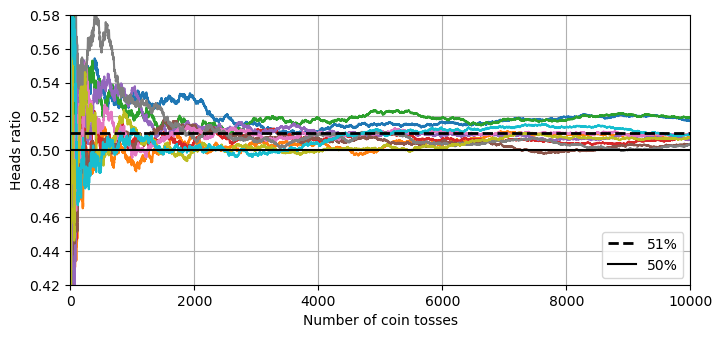

In [54]:
# 2. the law of large numbers
# 10 persons, each tosses this biased coin until 10,000 times
# everyone gets heads with a heads ratio converged to 51%
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / times

fig2, axes2 = plt.subplots(figsize=(8, 3.5))
axes2.plot(cumulative_heads_ratio)
axes2.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
axes2.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
axes2.set_xlabel("Number of coin tosses")
axes2.set_ylabel("Heads ratio")
axes2.legend(loc="lower right")
axes2.axis([0, 10000, 0.42, 0.58])
axes2.grid()

In [55]:
# 3. Exploit VotingClassifier
# give it a list of name/predictor pairs, 
# and use it like a normal classifier.

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = skds.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    # blueprints in the attribute estimators
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
# when fitting a VotingClassifier, 
# a copy is made from each blueprint then fitted
# the fitted members are in the attribute named_estimators_
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [56]:
# the score of each member learner is less than the ensemble's
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [57]:
voting_clf.score(X_test, y_test)

0.912

## Hard voting vs. soft voting
- hard voting votes by majority
- soft voting votes by probability

In [58]:
# 1. hard voting
# the final prediction is the prediction by the majority
# `voting_clf.predict` performs hard voting
# i.e. decided by the majority
voting_clf.predict(X_test[:1]), [clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

(array([1]), [array([1]), array([1]), array([0])])

### soft voting
- supported by the method `predict_proba()`
- it predicts the class with the highest class probability 
  - averaged over all the individual classifiers
- It often achieves higher performance than hard voting 
  - because it gives more weight to highly confident votes
- turned on by setting the voting hyperparameter to "soft"
  - requires that all members can estimate class probabilities
  - ⚠️ SVC does not estimate class probabilities by default
    - needs to be enabled by setting its `probability` hyperparameter to be True

In [59]:
# 2. enable soft voting then retrain model
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

In [60]:
mem_probs = [clf.predict_proba(X_test[:1]) for clf in voting_clf.estimators_]
voting_clf.predict_proba(X_test[:1]), mem_probs

(array([[0.51627522, 0.48372478]]),
 [array([[0.49899618, 0.50100382]]),
  array([[0.48, 0.52]]),
  array([[0.56982947, 0.43017053]])])

In [61]:
np.mean(mem_probs, axis=0)

array([[0.51627522, 0.48372478]])

# Bagging and Pasting
- There are two popular ways to get a diverse set of member predictors
  - one uses very different training algorithms on the same training set, or
  - the other one uses the same training algorithm for every member predictor 
    - but trains them on different random subsets of the training set
      - sampling the training set with replacement is called `bagging`
        - short for `bootstrap aggregating`
      - sampling the training set without replacement is called `pasting`
      - both bagging and pasting are scalable,
        - i.e can be processed in parallel
- generally, the ensemble has a similar bias but a lower variance than a member predictor

## Bagging and Pasting in Scikit-Learn
- both are supported by 
  - BaggingClassifier class for classification
  - BaggingRegressor for regression
- bagging is by default (`bootstrap=True`) since it often results in better models
  - since its training samples for each predictor are drawn from the whole training set
  - `bootstrap=False` for pasting
- `n_jobs` specifies the number of CPU cores to use for training and predictions
  - `n_jobs=-1`  uses all available cores
- A BaggingClassifier automatically performs soft voting instead of hard voting 
  - if the base classifier has a predict_proba() method, 
    - such as decision tree classifiers

In [62]:
# 1.  train an ensemble of 500 decision tree classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

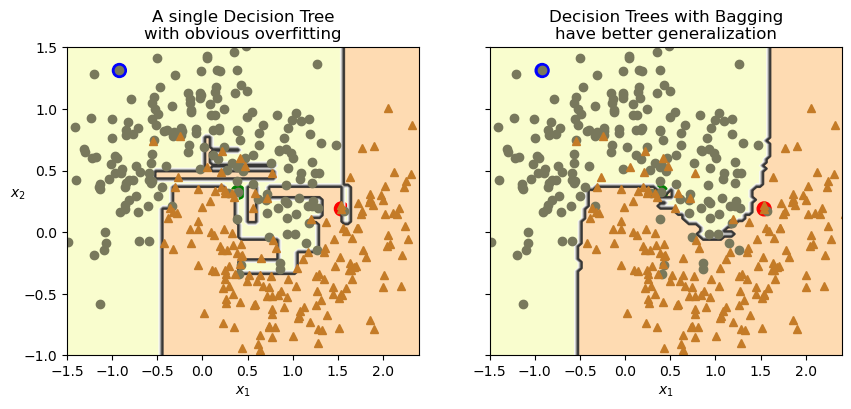

In [63]:
# 2.  A single decision tree vs. a bagging ensemble of 500 trees

def plot_decision_boundary(ax, clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    ax.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    ax.contour(x1, x2, y_pred, alpha=0.8 * alpha, cmap="Greys")
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        ax.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    ax.scatter(X[:3,0], X[:3,1], s=100, color=['red','green','blue'],zorder=1)
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig3, axes3 = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plot_decision_boundary(axes3[0], tree_clf, X_train, y_train)
axes3[0].set_title("A single Decision Tree\nwith obvious overfitting")

plot_decision_boundary(axes3[1], bag_clf, X_train, y_train)
axes3[1].set_title("Decision Trees with Bagging\nhave better generalization")
axes3[1].set_ylabel("");

## Out-of-Bag Evaluation
- In bagging, sampling with replacement, for any given predictor
  - Some training instances may be sampled several times
    - while others may not be sampled at all
  - About $63.22\%\approx 1-e^{-1}$ of the training instances are sampled on average for each predictor
    - The un-sampled remaining $36.78\% \approx e^{-1}$ are called `out-of-bag (OOB)` instances
    - Note that they are not the same $36.78\%$ for all predictors
    - The percentage $36.78\% is obtained by the idea that in 1 pick
      - each instance is chosen with a probability of $\frac{1}{n}$ out of $n$ instances, 
      - i.e. with a probability of not being chosen $1-\frac{1}{n}$
      - ∴ the probability that each instance is not chosen in $n$ picks is $(1-\frac{1}{n})^n \rightarrow e^{-1}$ when $n$ approaches ∞
  - Therefor, a bagging ensemble can be evaluated using OOB instances
    - without the need for a separate validation set
    - each instance in the training set will likely be an OOB instance of several estimators
    - Setting `oob_score=True` in BaggingClassifier constructor enables automatic OOB evaluation after training


In [64]:
# 1. Evaluate a BaggingClassifier with OOB instances
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [65]:
# 2. verify this oob_score with accuracy_score
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [66]:
# probas for the first 3 OOB instances chosen for evaluation
bag_clf.oob_decision_function_[:3]  

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

## Random Patches and Random Subspaces
- The BaggingClassifier class supports sampling the features as well
  - controlled by two hyperparameters: max_features and bootstrap_features
    - similar to instance sampling hyperparameters: max_samples and bootstrap
  - each predictor will be trained on a random subset of the input features
  - useful for dealing with high-dimensional inputs (such as images)
- Sampling both training instances and features is called `the random patches method`
- Sampling features only (by setting bootstrap_features to True and/or max_features to a value smaller than 1.0) is called the `random subspaces method`
  - this results in even more predictor diversity, trading a bit more bias for a lower variance

# Random Forests (RFs)
- A random forest is an ensemble of decision trees, typically
  - trained via the bagging method or pasting
  - with `max_samples` = the size of the training set
  - implemented as `RandomForestClassifier` and `RandomForestRegressor`
    - with all the hyperparameters of `BaggingClassifier+DecisionTreeClassifier`
- RF algorithm introduces extra randomness when growing trees
  - instead of searching for the very best feature when splitting a node
  - it searches for the best feature among a random subset of features
    - default to $\sqrt{m}$ features ($m$ is the total number of features)
  - this results in greater tree diversity, 
    - which trades a higher bias for a lower variance, 
    - generally yielding an overall better model

In [67]:
# 1. Create and train a random forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [68]:
# 2. A Random Forest is equivalent to a bag of decision trees
# pay attention to their parameters
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [69]:
# 3. same predictions if they are created with identical parameters
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  

True

## Extra-Trees
- short for `extremely randomized trees`
- created from `DecisionTreeClassifier` by setting `splitter="random"`
  - this setting uses random thresholds for each feature rather than searching for the best possible thresholds 
  - this technique trades more bias for a lower variance
    - and makes extra-trees classifiers much faster to train than regular random forests
- supported by `ExtraTreesClassifier` and `ExtraTreesRegressor`
- To compare `RandomForest*` vs. `ExtraTrees*`, we resort to cross-validation

## Feature Importance
- Random forests can be used for *feature selection* 
  - since it can show the relative importance of each feature
- RFs measure feature's importance by 
  - how much they are used by the tree nodes to reduce impurity on *average*
    - across all trees in the forest
  - this is an average weighted with each node’s number of training samples
    - it is calculated and normalized automatically after training
      - saved in attribute `feature_importances_`


In [70]:
# 1. Determine the feature's importance of the iris dataset 
iris = skds.load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


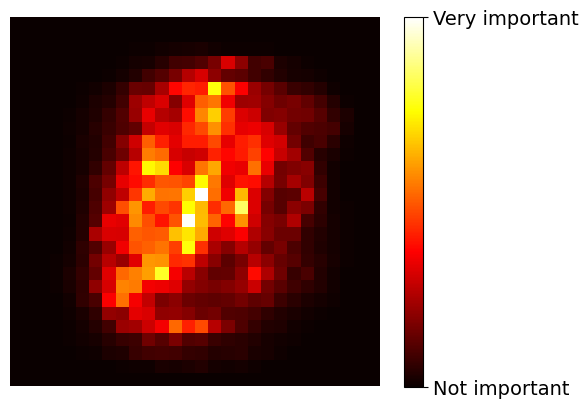

In [71]:
# 2. Determine each pixel’s importance of the MNIST dataset
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off");

# Boosting
- short for `hypothesis boosting`
  - refers to any ensemble method that can combine several weak learners into a strong learner
- The general idea of most boosting methods is to 
  - train predictors sequentially, each trying to correct its predecessor
- Two popular boosting methods
  - AdaBoost, short for adaptive boosting
  - gradient boosting

## [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)
- trains its member predictors in sequential
  - $P_1 \rightarrow P_2 \rightarrow P_3 \rightarrow \cdots P_i, \cdots, \rightarrow P_E$
    - $E$ is the number of members in the ensemble
  - this incurs a natural drawback: `non-scalable`
- each predictor pays a bit more attention to the training instances underfit by its predecessor
  - therefor does a better job on these mispredicted instances
  - by increasing the relative weight of these training instances
    - each sample weight $w^{(h)}$ is initially set to $\frac{1}{n}$
      - the weighted error rate of $P_i$: $\displaystyle r_i = \sum_{\substack{r=1\\ \hat{y}_i^{(h)} \neq y^{(h)} }}^n w^{(h)}$
        - $\hat{y}_i^{(h)}$ is $P_i$'s prediction for the $h^{th}$ sample
    - the boosting of misclassified instance weights is controlled by $P_i$'s predictor weight $\alpha_i$
      - $\displaystyle w^{(h)} = \begin{cases}w^{(h)} & \text{ if } \hat{y}_i^{(h)} &= y^{(h)}\\ w^{(h)}e^{\alpha_i} & \text{ if } \hat{y}_i^{(h)} &\neq y^{(h)}\end{cases}$
        - higher predictor weight, more boost
      - then all the instance weights are divided by $\sum_{h=1}^n w^{(h)}$ for normalization
    - $P_i$'s predictor weight $\alpha_i$ is proportional to the learning rate hyperparameter $\eta$ (initially set to be 1)
      - $\displaystyle \alpha_i = \eta \log\frac{1-r_i}{r_i}$
        - $\alpha_i>0$ when $r_i<0.5$, 
        - $\alpha_i=0$ when $r_i=0.5$,
        - $\alpha_i<0$ when $r_i>0.5$
      - the more accurate the predictor is, i.e. smaller $r_i$, the higher its weight will be
- This sequential learning technique has some similarities with gradient descent (GD)
  - GD tweaks a single predictor’s parameters to minimize a cost function  
  - But AdaBoost adds predictors to the ensemble, gradually making it better
- The ensemble makes predictions very much like bagging or pasting, 
  - except that predictors have different weights depending on their overall accuracy on the weighted training set
  - AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $α_i$
    - The predicted class is the one that receives the majority of weighted votes
      - $\displaystyle \hat{y}(\mathbf{x}) = \underset{k}{\operatorname{argmax}} \sum_{\substack{i=1\\ \hat{y_i}(\mathbf{x})=k}}^E α_i$

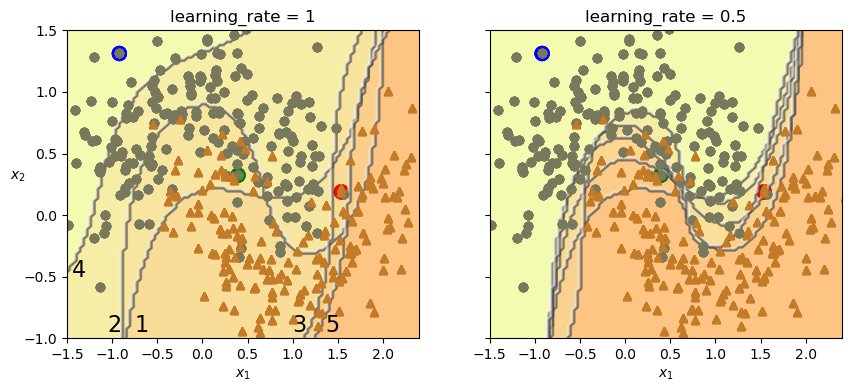

In [72]:
# Decision boundaries of consecutive predictors in AdaBoost
# on the moons dataset

n = len(X_train)

fig4, axes4 = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(n) / n
    ax = axes4[subplot]
    for i in range(5):
        #  a highly regularized SVM classifier with an RBF kernel is used
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * n)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        # Weighted error rate of the current predictor
        r = error_weights / sample_weights.sum()  
        # current predictor's weight
        alpha = learning_rate * np.log((1 - r) / r) 
        # update weights
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()  # normalize weights

        plot_decision_boundary(ax, svm_clf, X_train, y_train, alpha=0.4)
        ax.set_title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        ax.text(-0.75, -0.95, "1", fontsize=16)
        ax.text(-1.05, -0.95, "2", fontsize=16)
        ax.text(1.0, -0.95, "3", fontsize=16)
        ax.text(-1.45, -0.5, "4", fontsize=16)
        ax.text(1.36,  -0.95, "5", fontsize=16)
    else:
        ax.set_ylabel("")


## SAMME
- short for `Stagewise Additive Modeling using a Multiclass Exponential loss function`
- provided in sklearn as a multiclass version of AdaBoost
  - implemented as `AdaBoostClassifier`
  - SAMME for two classes is equivalent to AdaBoost
- A variant of SAMME called SAMME.R (the R stands for “Real”) is used 
  - when the member predictors have a `predict_proba()` method
  - i.e. they can estimate class probabilities
- SAMME.R generally performs better with class probabilities rather than predictions
- Two ways to mitigate AdaBoost ensemble overfitting
  - Reduce the number of estimators 
  - Regularize the base estimator more strongly
- The default base estimator of `AdaBoostClassifier` is a decision stumps
  - which is a decision tree with max_depth=1,
  - i.e. a tree composed of a single decision node plus two leaf nodes

In [73]:
# 1. an AdaBoost classifier based on 30 decision stumps 

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

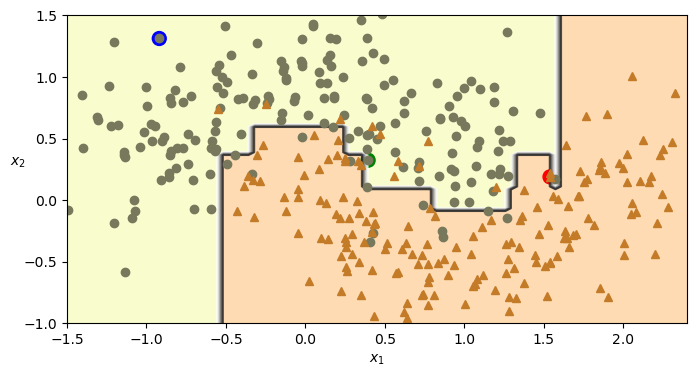

In [74]:
# 2. the decision boundary for the AdaBoost classifier
fig5, axes5 = plt.subplots(figsize=(8, 4), sharey=True)

plot_decision_boundary(axes5, ada_clf, X_train, y_train)

## Gradient Boosting
- works like AdaBoost by sequentially adding predictors to an ensemble 
  - each one correcting its predecessor
- tries to fit the new predictor to the residual errors made by the previous predictor
  - instead of tweaking the instance weights at every iteration like AdaBoost does
- `gradient tree boosting` uses decision trees as the base predictors
  - also called `gradient boosted regression trees (GBRT)`

In [75]:
# manual Gradient Boosting flow
# 1. fit a DecisionTreeRegressor to a noisy quadratic dataset
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [76]:
# 2. train two more decision tree regressors
# each on the residual errors made by the previous predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [77]:
# 3. Now we have an ensemble containing three trees. 
# It can make predictions on a new instance simply by 
# adding up the predictions of all the trees

X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

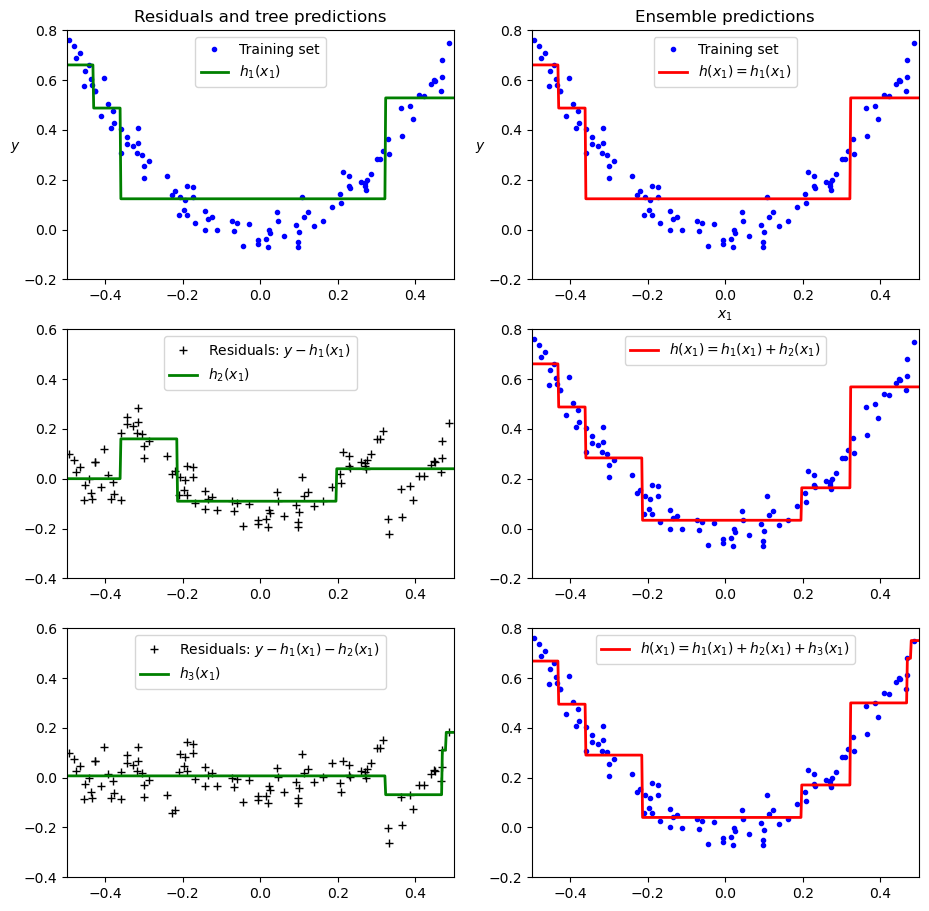

In [78]:
# 4. visualize the predictions by the decision trees and the ensembles
# the ensemble’s predictions gradually get better 
#   as trees are added to the ensemble

def plot_predictions(ax, regressors, X, y, axis, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axis[0], axis[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    ax.plot(X[:, 0], y, data_style, label=data_label)
    ax.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        ax.legend(loc="upper center")
    ax.axis(axis)

fig6, axes6 = plt.subplots(3,2,figsize=(11, 11))

plot_predictions(axes6[0,0], [tree_reg1], X, y, axis=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
axes6[0,0].set_ylabel("$y$  ", rotation=0)
axes6[0,0].set_title("Residuals and tree predictions")

plot_predictions(axes6[0,1], [tree_reg1], X, y, axis=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
axes6[0,1].set_title("Ensemble predictions")

plot_predictions(axes6[1,0], [tree_reg2], X, y2, axis=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
axes6[0,1].set_ylabel("$y$  ", rotation=0)

plot_predictions(axes6[1,1], [tree_reg1, tree_reg2], X, y, axis=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plot_predictions(axes6[2,0], [tree_reg3], X, y3, axis=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
axes6[0,1].set_xlabel("$x_1$")
axes6[0,1].set_ylabel("$y$  ", rotation=0)

plot_predictions(axes6[2,1], [tree_reg1, tree_reg2, tree_reg3], X, y,
                 axis=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
axes6[0,1].set_xlabel("$x_1$");


- GBRT can be trained with two off-the-shelf sklearn classes
  - `GradientBoostingRegressor` class for regression
  - `GradientBoostingClassifier` class for classification
- both classes have hyperparameters to control 
  - the growth of decision trees
  - the ensemble training, such as the number of trees (n_estimators)
- both also have a regularization technique called `shrinkage` controlled by 
  - the `learning_rate` hyperparameter 
- `learning_rate` scales the contribution of each tree
  - the lower `learning_rate`, the more trees are needed to fit the training set
  - but the predictions will usually generalize better
- If too more trees are added, the GBRT would start to overfit the training set
- the optimal number of trees can be found with cross-validation such as
 - GridSearchCV or RandomizedSearchCV
 - or early stopping by setting hyperparameter `n_iter_no_change` = n
   - the GBRT will automatically stop adding more trees 
   - if it sees that the last n trees didn’t help during training
 - risk of setting `n_iter_no_change`
   - too small, training may stop too early and the model will underfit
   - too large, it will overfit

In [79]:
# 1. use GradientBoostingRegressor to implement 
#   an equivalent of the manual threes above
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [80]:
# 2. a better GradientBoostingRegressor obtained with early stopping
# lower learning_rate, heavier regularization, more trees are needed
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [81]:
# the actual number of estimators in the trained ensemble is much lower, 
# thanks to early stopping
gbrt_best.n_estimators_

92

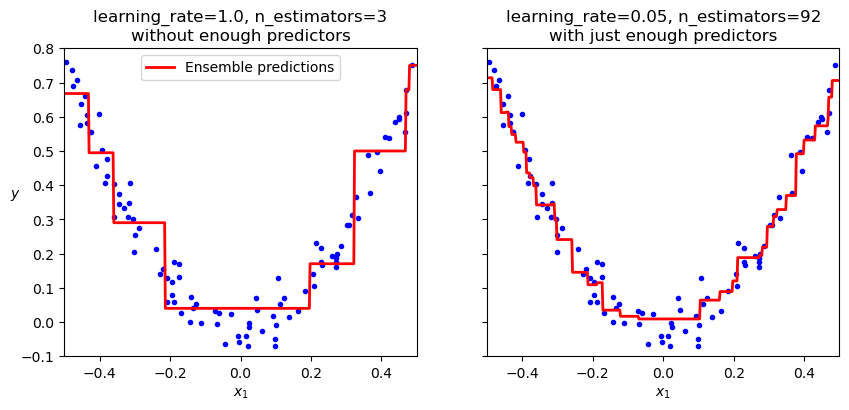

In [82]:
# 3. visualize the two GBRTs
fig7, axes7 = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plot_predictions(axes7[0], [gbrt], X, y, axis=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
axes7[0].set_title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}"
          f'\nwithout enough predictors')
axes7[0].set_xlabel("$x_1$")
axes7[0].set_ylabel("$y$", rotation=0)

plot_predictions(axes7[1], [gbrt_best], X, y, axis=[-0.5, 0.5, -0.1, 0.8], style="r-")
axes7[1].set_title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}"
          f'\nwith just enough predictors')
axes7[1].set_xlabel("$x_1$");

- When `n_iter_no_change` is set, the `fit()` method automatically exploit cross-validation
  - to evaluate the model’s performance each time it adds a new tree
- The `validation_fraction` hyperparameter, which is 10% by default
- The `tol` hyperparameter determines the negligible maximum performance improvement 
  - defaults to 0.0001
- The `subsample` hyperparameter specifies the fraction of training instances 
  - to be randomly selected for training each tree
  - this technique trades a higher bias for a lower variance
    - but speeds up training considerably
  - This is called `stochastic gradient boosting`

## Histogram-Based Gradient Boosting (HGB)
- optimized for large datasets
- works by binning the input features encoded with integers
  - the number of bins is specified by the `max_bins` hyperparameter
    - no more than 255
- Binning can greatly reduce the number of possible feature thresholds
- Working with integers is faster and more memory-efficient
  - no need for sorting the features when training each tree
  - given n samples with m features and b bins, 
    - the time complexity is $O(b\times n)$
    - much faster than the decision tree complexity $O(mn\log_2 n)$
- Binning causes precision loss, which acts as a regularizer: 
    - depending on the dataset, this may help reduce overfitting
    - or it may cause underfitting
- HGB is implemented in two sklearn classes
  - `HistGradientBoostingRegressor` and `HistGradientBoostingClassifier`

In [83]:
# Build and train a complete pipeline for the California housing dataset
# using HistGradientBoostingRegressor

# 1. load the dataset of California house prices
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./datasets/housing.csv")

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [84]:
housing_labels.describe()

count     16512.000000
mean     206111.152980
std      114790.075691
min       14999.000000
25%      119400.000000
50%      179200.000000
75%      263800.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [85]:
# 2. create a ML pipeline: OrdinalEncoder --> HistGradientBoostingRegressor
# No need for an imputer, scaler, or a one-hot encoder
# no hyperparameter tuning

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    # Note that categorical_features must be set to 
    # the categorical column indices (or a Boolean array)
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [86]:
# 3. evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

In [87]:
pd.Series(hgb_rmses).describe()['mean'] / housing_labels.describe()['mean']

0.23100791250665692

# Stacking
- short for stacked generalization
- uses a model to aggregate the predictions of all predictors
  - instead of trivial functions (such as hard voting)
- i.e. uses all predictors's prediction as input features, the original target as target
- this is why it is called stacking
  - stack an aggregation model on a group of predictors as layer 1 feeding on the training set
  - we can also create a group of aggregators as layer 2
    - then stack an aggregator on layer 2
  - many layers can be stacked to squeeze out a few more drops of performance
    - but it will cost in both training time and system complexity
- implemented in two sklearn classes: `StackingClassifier` and `StackingRegressor`
- For each predictor, the prediction methods preferred by StackingClassifier in descending order
  - `predict_proba()`, `decision_function()`, `predict()`
- If no final estimator is provided, 
  - StackingClassifier will use LogisticRegression, 
  - StackingRegressor will use RidgeCV

In [88]:
# F1. it the moons dataset used in VotingClassifier with
# StackingClassifier

from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [89]:
# 2. compare their performance
stacking_clf.score(X_test, y_test), voting_clf.score(X_test, y_test)

(0.928, 0.92)

# References
- [sklearn: Ensembles: Gradient boosting, random forests, bagging, voting, stacking](https://scikit-learn.org/stable/modules/ensemble.html)
- [Random Forests out-of-bag sample size](https://stats.stackexchange.com/questions/173520/random-forests-out-of-bag-sample-size)